## King County Property Price Prediction
This notebook explores a dataset that contains home prices in King County in Washington state in the years 2014-2015. The full dataset contains 21,613 samples from May 2, 2014 to May 27, 2015. However, we chose to downsample the dataset based on the price feature to exclude outlying home prices from the model. The source for this dataset is kaggle.com: https://www.kaggle.com/harlfoxem/housesalesprediction

### Metadata Analysis
The dataset contains 21 features, one of which is sample identifier ('id'). There are no null values in the dataset and the timezone is in UTC format. There are 618 samples in which the square feet of living space ('sqft_living15') is more than the square feet of the lot ('sqft_lot15'). There are 914 homes which have been renovated and 163 homes with a waterfront view. The only string field is the date column - the rest are integers and floats. 

In [68]:
import pandas as pd
import numpy as np
from datetime import datetime
from pytz import timezone
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle
from collections import OrderedDict
%matplotlib inline

In [2]:
king_df = pd.read_csv('kc_house_data.csv')

In [3]:
king_df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [4]:
king_df.shape

(21613, 21)

In [5]:
king_df.columns.values

array(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype=object)

In [6]:
king_df.isnull().any().sum()

0

In [7]:
king_df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [8]:
min(king_df['date'])

'20140502T000000'

In [9]:
max(king_df['date'])

'20150527T000000'

In [10]:
np.where(king_df['sqft_living15'] > king_df['sqft_lot15'], 1, 0).sum()

618

In [11]:
king_df[king_df['sqft_living15'] > king_df['sqft_lot15']]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
133,8929000270,20140512T000000,453246.0,3,2.50,2010,2287,2.0,0,0,...,8,1390,620,2014,0,98029,47.5517,-121.998,1690,1662
139,2767603505,20140507T000000,519950.0,3,2.25,1170,1249,3.0,0,0,...,8,1170,0,2014,0,98107,47.6722,-122.381,1350,1310
209,6300000550,20140717T000000,464000.0,6,3.00,2300,3404,2.0,0,0,...,7,1600,700,1920,1994,98133,47.7067,-122.343,1560,1312
400,9126100861,20150306T000000,557000.0,3,3.50,1710,2096,2.0,0,0,...,8,1290,420,2008,0,98122,47.6055,-122.305,1630,1543
405,9385200055,20140912T000000,650000.0,3,3.25,1510,2000,2.0,0,0,...,9,1330,180,2001,0,98116,47.5815,-122.402,1510,1352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21601,5100403806,20150407T000000,467000.0,3,2.50,1425,1179,3.0,0,0,...,8,1425,0,2008,0,98125,47.6963,-122.318,1285,1253
21604,9834201367,20150126T000000,429000.0,3,2.00,1490,1126,3.0,0,0,...,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21607,2997800021,20150219T000000,475000.0,3,2.50,1310,1294,2.0,0,0,...,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509


In [12]:
king_df[king_df['yr_renovated']!=0]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
35,9547205180,20140613T000000,696000.0,3,2.50,2300,3060,1.5,0,0,...,8,1510,790,1930,2002,98115,47.6827,-122.310,1590,3264
95,1483300570,20140908T000000,905000.0,4,2.50,3300,10250,1.0,0,0,...,7,2390,910,1946,1991,98040,47.5873,-122.249,1950,6045
103,2450000295,20141007T000000,1088000.0,3,2.50,2920,8113,2.0,0,0,...,8,2920,0,1950,2010,98004,47.5814,-122.196,2370,8113
115,3626039325,20141121T000000,740500.0,3,3.50,4380,6350,2.0,0,0,...,8,2780,1600,1900,1999,98117,47.6981,-122.368,1830,6350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19622,7351200295,20150114T000000,1150000.0,3,1.75,1760,6788,2.0,1,4,...,7,1760,0,1940,1960,98125,47.7336,-122.284,1630,7588
20057,126039256,20140904T000000,434900.0,3,2.00,1520,5040,2.0,0,0,...,7,1520,0,1977,2006,98177,47.7770,-122.362,1860,8710
20444,4305600360,20150225T000000,500012.0,4,2.50,2400,9612,1.0,0,0,...,8,1230,1170,1962,2009,98059,47.4799,-122.127,2430,5539
20447,3319500628,20150212T000000,356999.0,3,1.50,1010,1546,2.0,0,0,...,8,1010,0,1971,2014,98144,47.5998,-122.311,1010,1517


In [13]:
pd.cut(king_df['price'], bins=10).value_counts().sort_index()

(67375.0, 837500.0]       19022
(837500.0, 1600000.0]      2165
(1600000.0, 2362500.0]      298
(2362500.0, 3125000.0]       90
(3125000.0, 3887500.0]       26
(3887500.0, 4650000.0]        4
(4650000.0, 5412500.0]        4
(5412500.0, 6175000.0]        1
(6175000.0, 6937500.0]        1
(6937500.0, 7700000.0]        2
Name: price, dtype: int64

In [14]:
king_df[king_df['price'] > 3887500].sort_values('price', ascending=False)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7252,6762700020,20141013T000000,7700000.0,6,8.00,12050,27600,2.5,0,3,...,13,8570,3480,1910,1987,98102,47.6298,-122.323,3940,8800
3914,9808700762,20140611T000000,7062500.0,5,4.50,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.6500,-122.214,3930,25449
9254,9208900037,20140919T000000,6885000.0,6,7.75,9890,31374,2.0,0,4,...,13,8860,1030,2001,0,98039,47.6305,-122.240,4540,42730
4411,2470100110,20140804T000000,5570000.0,5,5.75,9200,35069,2.0,0,0,...,13,6200,3000,2001,0,98039,47.6289,-122.233,3560,24345
1448,8907500070,20150413T000000,5350000.0,5,5.00,8000,23985,2.0,0,4,...,12,6720,1280,2009,0,98004,47.6232,-122.220,4600,21750
1315,7558700030,20150413T000000,5300000.0,6,6.00,7390,24829,2.0,1,4,...,12,5000,2390,1991,0,98040,47.5631,-122.210,4320,24619
1164,1247600105,20141020T000000,5110800.0,5,5.25,8010,45517,2.0,1,4,...,12,5990,2020,1999,0,98033,47.6767,-122.211,3430,26788
8092,1924059029,20140617T000000,4668000.0,5,6.75,9640,13068,1.0,1,4,...,12,4820,4820,1983,2009,98040,47.5570,-122.210,3270,10454
2626,7738500731,20140815T000000,4500000.0,5,5.50,6640,40014,2.0,1,4,...,12,6350,290,2004,0,98155,47.7493,-122.280,3030,23408
8638,3835500195,20140618T000000,4489000.0,4,3.00,6430,27517,2.0,0,0,...,12,6430,0,2001,0,98004,47.6208,-122.219,3720,14592


In [15]:
king_df['waterfront'].value_counts()

0    21450
1      163
Name: waterfront, dtype: int64

In [16]:
king_df[(king_df['sqft_living15']*5 < king_df['sqft_lot15']) & (king_df['sqft_living15'] > 3000) & (king_df['view'] >= 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
216,46100204,20150221T000000,1505000.0,5,3.00,3300,33474,1.0,0,3,...,9,1870,1430,1957,1991,98040,47.5673,-122.210,3836,20953
246,2025069065,20140929T000000,2400000.0,4,2.50,3650,8354,1.0,1,4,...,9,1830,1820,2000,0,98074,47.6338,-122.072,3120,18841
409,1560930070,20140911T000000,840000.0,4,3.50,2840,40139,1.0,0,4,...,10,2840,0,1986,0,98038,47.4010,-122.026,3180,36852
527,3225079035,20140618T000000,1600000.0,6,5.00,6050,230652,2.0,0,3,...,11,6050,0,2001,0,98024,47.6033,-121.943,4210,233971
540,622049114,20150218T000000,2125000.0,3,2.50,5403,24069,2.0,1,4,...,12,5403,0,1976,0,98166,47.4169,-122.348,3980,104374
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20295,251500080,20140826T000000,3204000.0,4,4.00,4810,18851,2.0,0,3,...,11,4810,0,2007,0,98004,47.6364,-122.214,3970,19929
20920,2124069115,20141021T000000,1830000.0,4,4.25,4500,215186,2.0,0,3,...,11,2630,1870,2009,0,98029,47.5590,-122.045,3030,25447
21050,2424059170,20150219T000000,900000.0,5,6.00,7120,40806,2.0,0,4,...,12,5480,1640,2007,0,98006,47.5451,-122.114,3440,36859
21344,8835770170,20140822T000000,1488000.0,5,6.00,6880,279968,2.0,0,3,...,12,4070,2810,2007,0,98045,47.4624,-121.779,4690,256803


In [17]:
king_df['view'].value_counts().sort_index()

0    19489
1      332
2      963
3      510
4      319
Name: view, dtype: int64

In [18]:
king_df[king_df['price'] <= 1600000.0].shape

(21187, 21)

### Data Cleaning and Preprocessing
We will look at the houses that are equal to or below $1,600,000. We will also convert the UTC formatted 'date' column into a timestamp that is in Pacific Standard Time. From this, we will create a time series based dataset and a standard dataset. The time series dataset will be used for time series analysis, with the dataset sorted by ascending date (in PST), whereas the standard dataset will be unsorted. The date column will be dropped after both the sorted (time series) and standard datasets have been created.

In [19]:
dataset = pd.DataFrame(king_df[king_df['price'] <= 1600000.0]).set_index('id')

In [20]:
dataset.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [21]:
dataset.shape

(21187, 20)

In [22]:
date_format ='%m/%d/%Y %H:%M:%S'
dataset['date'] = pd.to_datetime(dataset['date'])
dataset['date'] = dataset['date'].dt.tz_localize('UTC')

In [23]:
dataset.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-13 00:00:00+00:00,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-09 00:00:00+00:00,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-25 00:00:00+00:00,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-09 00:00:00+00:00,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-18 00:00:00+00:00,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [24]:
dataset['date'] = dataset['date'].dt.tz_convert('US/Pacific')
dataset.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-12 17:00:00-07:00,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-08 16:00:00-08:00,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-24 16:00:00-08:00,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-08 16:00:00-08:00,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-17 16:00:00-08:00,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [25]:
time_series = dataset.sort_values('date', ascending=True)
time_series.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
1525079056,2014-05-01 17:00:00-07:00,284000.0,3,1.75,1800,23103,1.0,0,0,3,7,1800,0,1968,0,98014,47.6517,-121.906,1410,18163
943100683,2014-05-01 17:00:00-07:00,335000.0,3,2.25,1580,16215,1.0,0,0,4,7,1580,0,1978,0,98024,47.5643,-121.897,1450,16215
7525410190,2014-05-01 17:00:00-07:00,550000.0,3,1.75,2910,35200,1.5,0,0,3,8,2910,0,1979,0,98075,47.5747,-122.035,2590,37500
7831800460,2014-05-01 17:00:00-07:00,235000.0,2,1.00,1210,9400,1.0,0,0,2,6,1210,0,1949,0,98106,47.5342,-122.360,1580,6026
2618300080,2014-05-01 17:00:00-07:00,242500.0,3,1.50,1200,9720,1.0,0,0,4,7,1200,0,1965,0,98042,47.4225,-122.153,1380,10284


In [26]:
standard_series = dataset
standard_series.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,,
7129300520,2014-10-12 17:00:00-07:00,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
6414100192,2014-12-08 16:00:00-08:00,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
5631500400,2015-02-24 16:00:00-08:00,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2487200875,2014-12-08 16:00:00-08:00,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
1954400510,2015-02-17 16:00:00-08:00,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [27]:
time_series.drop(['date'], axis=1, inplace=True)

In [28]:
standard_series.drop(['date'], axis=1, inplace=True)

### Exploratory Data Analysis
We use matplotlib and seaborn to explore both the time series and standard series datasets to see if we can determine which features most contribute to home prices before we build our machine learning models. 

In [29]:
dataset.columns.values

array(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15'], dtype=object)

In [30]:
len(dataset['zipcode'].unique())

70

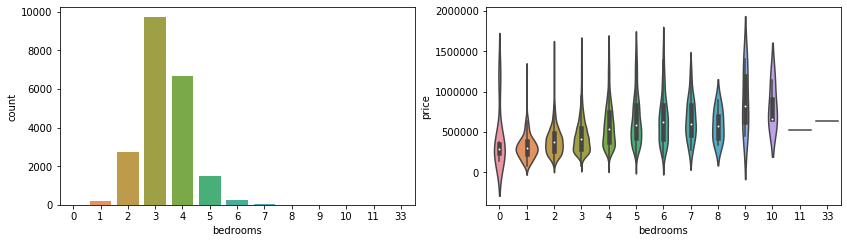

In [31]:
plt.figure(figsize=(14,8))
ax1 = plt.subplot(221)
sns.countplot(dataset['bedrooms'], ax=ax1)
ax2 = plt.subplot(222)
sns.violinplot(x=dataset['bedrooms'], y=dataset['price'], ax=ax2)

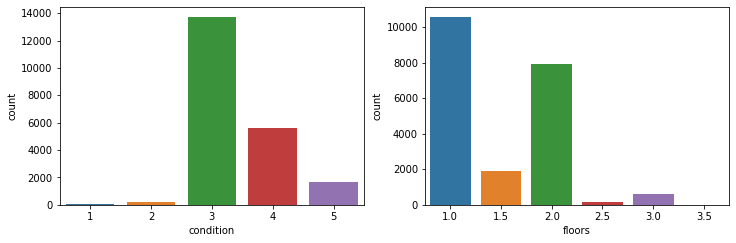

In [32]:
plt.figure(figsize=(12,8))
ax1 = plt.subplot(221)
sns.countplot(dataset['condition'], ax=ax1)
ax2 = plt.subplot(222)
sns.countplot(dataset['floors'], ax=ax2)

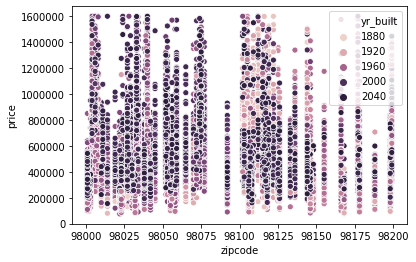

In [33]:
sns.scatterplot(x=dataset['zipcode'],y=dataset['price'], hue=dataset['yr_built'])

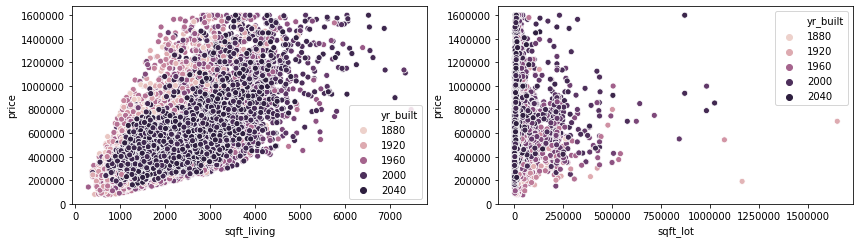

In [34]:
plt.figure(figsize=(14,8))
ax1 = plt.subplot(221)
sns.scatterplot(x=dataset['sqft_living'],y=dataset['price'], hue=dataset['yr_built'], ax=ax1)
ax2 = plt.subplot(222)
sns.scatterplot(x=dataset['sqft_lot'],y=dataset['price'], hue=dataset['yr_built'], ax=ax2)

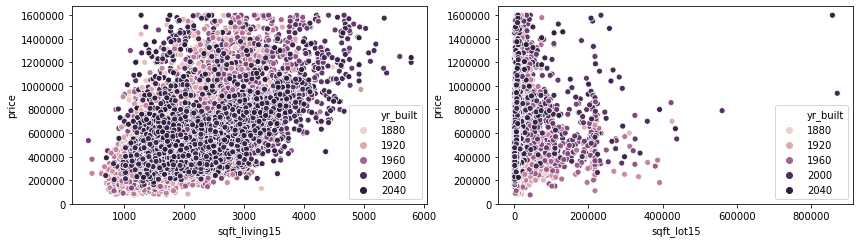

In [35]:
plt.figure(figsize=(14,8))
ax3 = plt.subplot(221)
sns.scatterplot(x=dataset['sqft_living15'],y=dataset['price'], hue=dataset['yr_built'], ax=ax3)
ax4 = plt.subplot(222)
sns.scatterplot(x=dataset['sqft_lot15'],y=dataset['price'], hue=dataset['yr_built'], ax=ax4)

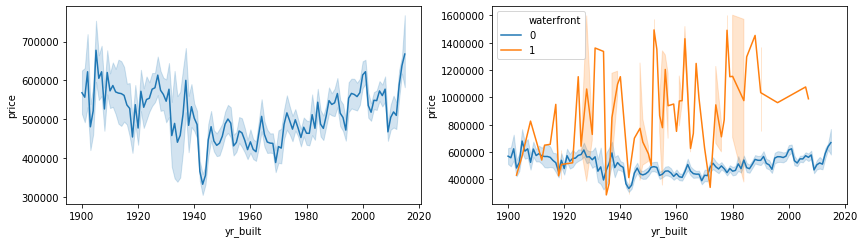

In [36]:
plt.figure(figsize=(14,8))
ax1 = plt.subplot(221)
sns.lineplot(x=dataset['yr_built'],y=dataset['price'], ax=ax1)
ax2 = plt.subplot(222)
sns.lineplot(x=dataset['yr_built'],y=dataset['price'], hue=dataset['waterfront'], ax=ax2)

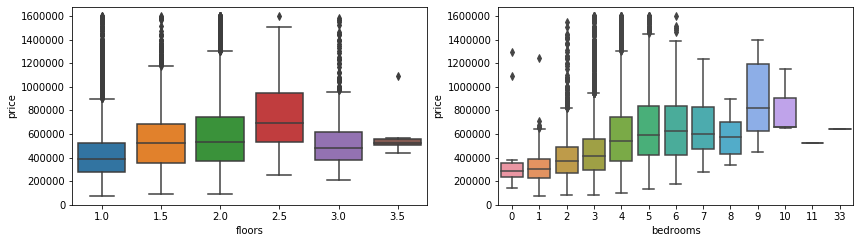

In [37]:
plt.figure(figsize=(14,8))
ax1 = plt.subplot(221)
sns.boxplot(x='floors', y='price', data=dataset)
ax2 = plt.subplot(222)
sns.boxplot(x='bedrooms', y='price', data=dataset)

In [38]:
dataset[dataset['condition']<3].zipcode.value_counts()[:5]

98118    18
98168    11
98146    10
98023     9
98058     7
Name: zipcode, dtype: int64

### Linear Regression Model
We use matplotlib and seaborn to explore both the time series and standard series datasets to see if we can determine which features most contribute to home prices before we build our machine learning models. 

In [39]:
data = standard_series.drop('price', axis=1)
target = standard_series['price']

In [40]:
nfold = 10
kfold = KFold(nfold)
data = np.array(data)
target = np.array(target)
lr = LinearRegression()
mse_score = []
r2_scores = []

for train, test in kfold.split(data):
    X_train, X_test, y_train, y_test = data[train], data[test], target[train], target[test]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mse_score.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

In [41]:
print('Fold MSE: ' + str(mse_score))
print('Average MSE: ' + str(sum(mse_score)/nfold))

Fold MSE: [17979453491.15141, 20021192659.676224, 18415987814.254307, 20124807785.93506, 17631006437.95015, 19781377928.323406, 16902936174.256039, 19711577670.368248, 20026110621.013294, 21674812980.730606]
Average MSE: 19226926356.365875


In [42]:
print('Fold R2: ' + str(r2_scores))
print('Average R2: ' + str(sum(r2_scores)/nfold))

Fold R2: [0.7280245759326156, 0.7092221094044637, 0.7149577071843987, 0.6943146684860506, 0.7171614637879158, 0.7046896245811685, 0.7257827522716546, 0.7148373325631001, 0.6950224890688916, 0.6805114041938183]
Average R2: 0.7084524127474077


In [43]:
data = standard_series.drop('price', axis=1)
target = standard_series['price']

In [44]:
X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.3)

In [45]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [46]:
y_pred = lr.predict(X_test)

In [47]:
mean_squared_error(y_test, y_pred)

19342421017.59658

In [48]:
r2_score(y_test, y_pred)

0.7101929321486526

In [57]:
len(lr.coef_)

18

In [66]:
keys = data.columns.values
values = lr.coef_
dicts = dict(zip(keys, values))

In [80]:
sorted(dicts.items(), key=lambda x:x[1])

[('long', -107945.94137336068),
 ('bedrooms', -13858.785651147686),
 ('yr_built', -2106.7697391696006),
 ('zipcode', -339.4522493091109),
 ('sqft_lot15', -0.15824699333927542),
 ('sqft_lot', 0.18492177640228236),
 ('yr_renovated', 19.210307309878658),
 ('sqft_basement', 29.043363183163336),
 ('sqft_above', 30.894419931281035),
 ('sqft_living15', 48.52242942572364),
 ('sqft_living', 59.93778335869941),
 ('condition', 27650.07849096834),
 ('bathrooms', 27724.220464368413),
 ('floors', 31538.05349060517),
 ('view', 41038.99883071251),
 ('grade', 86557.98792053819),
 ('waterfront', 191598.12107400593),
 ('lat', 570206.0708989111)]

In [127]:
nfold = 5
kfold = KFold(nfold)
features = np.array(data[['lat', 'waterfront', 'view', 'floors', 'bathrooms', 'sqft_living']])
target = np.array(target)
lr = LinearRegression()
mse_score = []
r2_scores = []

for train, test in kfold.split(features):
    X_train, X_test, y_train, y_test = features[train], features[test], target[train], target[test]
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    mse_score.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

In [128]:
print('Fold MSE: ' + str(mse_score))
print('Average MSE: ' + str(sum(mse_score)/nfold))


Fold MSE: [27034006704.71407, 26312208774.478596, 25773076426.543964, 25258213213.87708, 24689101956.560238]
Average MSE: 25813321415.23479


In [129]:
print('Fold R2: ' + str(r2_scores))
print('Average R2: ' + str(sum(r2_scores)/nfold))

Fold R2: [0.5994280588156208, 0.5969064851110795, 0.6015040132851888, 0.6136621208084762, 0.6327887036683315]
Average R2: 0.6088578763377394


In [120]:
data['grade'].value_counts()

7     8979
8     6050
9     2546
6     2038
10     991
11     277
5      242
12      31
4       29
3        3
1        1
Name: grade, dtype: int64

### Pickle Final Model
We use matplotlib and seaborn to explore both the time series and standard series datasets to see if we can determine which features most contribute to home prices before we build our machine learning models. 

In [133]:
X = data[['lat', 'waterfront', 'view', 'floors', 'bathrooms', 'sqft_living']]
y = target

In [134]:
model = lr.fit(X, y)

In [135]:
filename = 'king_model.sav'
pickle.dump(model, open(filename, 'wb'))